In [ ]:
!where python

c:\myworks\Phishing_Detect\venv\Scripts\python.exe
C:\Python312\python.exe
C:\Users\HP\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# %pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [9]:
# Load CSV from Kaggle path or local upload
# path = kagglehub.dataset_download("kaggleprollc/phishing-url-websites-dataset-phiusiil")

# # Construct the full path to the CSV file
# csv_file_path = os.path.join(path, "PhiUSIIL_Phishing_URL_Dataset.csv") # Added .csv extension

df = pd.read_csv("C:\myworks\Phishing_Detect\dataset\PhiUSIIL_Phishing_URL_Dataset.csv")  # Adjust the path as necessary

# Quick peek
print(df.head())
print(df.info())
print(df.describe())

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_15256\3578713003.py:7: SyntaxWarning: invalid escape sequence '\m'
  df = pd.read_csv("C:\myworks\Phishing_Detect\dataset\PhiUSIIL_Phishing_URL_Dataset.csv")  # Adjust the path as necessary


     FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2 

In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [11]:
target_col = 'label'  # change if different
# categorical_cols.remove(target_col) # Removed this line as 'label' is not in categorical_cols

In [12]:
from sklearn.preprocessing import StandardScaler, LabelEncoder # Added LabelEncoder

label_enc = LabelEncoder()
df[target_col] = label_enc.fit_transform(df[target_col])

In [13]:
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

print("\nEncoded Data Sample:\n", df.head())


Encoded Data Sample:
    FILENAME     URL  URLLength  Domain  DomainLength  IsDomainIP  TLD  \
0     62810  209013         31  187114            24           0  231   
1     30568  223747         23  204805            16           0  254   
2     79880  227579         29  209611            22           0  647   
3     69962  205082         26  182115            19           0  231   
4     11694  198761         33  173664            26           0  503   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2               100.0              0.866667           0.028555  ...    0   
3               100.0              1.000000           0.522907  ...    1   
4               100.0              1.000000           0.079963  ...    1   

   Crypto  HasCopyrightInfo  NoOfImage  NoOfCSS  NoOfJS  NoOfSelfRef  \
0       0

In [14]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Check for missing values
print(df.isnull().sum())


FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  int64  
 1   URL                         235795 non-null  int64  
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  int64  
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  int64  
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [16]:
print(df.shape)
# Calculate correlation with 'label'
corr_with_label = df.corr(numeric_only=True)['label']

# Keep only columns with |correlation| >= 0.4
cols_to_keep = corr_with_label[abs(corr_with_label) >= 0.4].index

# Filter dataset to keep only these columns
df_filtered = df[cols_to_keep]

print("Remaining columns:", df_filtered.columns.tolist())
print("Shape of new dataset:", df_filtered.shape)

(235795, 56)
Remaining columns: ['FILENAME', 'URL', 'Domain', 'URLSimilarityIndex', 'CharContinuationRate', 'URLCharProb', 'DegitRatioInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'IsResponsive', 'HasDescription', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasCopyrightInfo', 'label']
Shape of new dataset: (235795, 20)


In [17]:
# df_filtered.info()
df = df_filtered
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FILENAME               235795 non-null  int64  
 1   URL                    235795 non-null  int64  
 2   Domain                 235795 non-null  int64  
 3   URLSimilarityIndex     235795 non-null  float64
 4   CharContinuationRate   235795 non-null  float64
 5   URLCharProb            235795 non-null  float64
 6   DegitRatioInURL        235795 non-null  float64
 7   SpacialCharRatioInURL  235795 non-null  float64
 8   IsHTTPS                235795 non-null  int64  
 9   HasTitle               235795 non-null  int64  
 10  DomainTitleMatchScore  235795 non-null  float64
 11  URLTitleMatchScore     235795 non-null  float64
 12  HasFavicon             235795 non-null  int64  
 13  IsResponsive           235795 non-null  int64  
 14  HasDescription         235795 non-nu

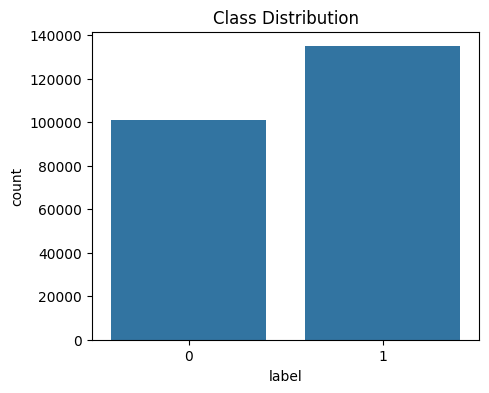

In [18]:
plt.figure(figsize=(5,4))
sns.countplot(x=target_col, data=df)
plt.title("Class Distribution")
plt.show()

In [19]:
label_corr = df.corr(numeric_only=True)['label'].sort_values(ascending=False)

print(label_corr)

label                    1.000000
URLSimilarityIndex       0.860358
URL                      0.818027
HasSocialNet             0.784255
HasCopyrightInfo         0.743358
HasDescription           0.690232
IsHTTPS                  0.609132
DomainTitleMatchScore    0.584905
HasSubmitButton          0.578561
IsResponsive             0.548608
URLTitleMatchScore       0.539419
HasHiddenFields          0.507731
HasFavicon               0.493711
Domain                   0.479922
URLCharProb              0.469749
CharContinuationRate     0.467735
HasTitle                 0.459725
DegitRatioInURL         -0.432032
SpacialCharRatioInURL   -0.533537
FILENAME                -0.727857
Name: label, dtype: float64


In [20]:
df = df.drop(['DegitRatioInURL', 'SpacialCharRatioInURL', 'FILENAME'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   URL                    235795 non-null  int64  
 1   Domain                 235795 non-null  int64  
 2   URLSimilarityIndex     235795 non-null  float64
 3   CharContinuationRate   235795 non-null  float64
 4   URLCharProb            235795 non-null  float64
 5   IsHTTPS                235795 non-null  int64  
 6   HasTitle               235795 non-null  int64  
 7   DomainTitleMatchScore  235795 non-null  float64
 8   URLTitleMatchScore     235795 non-null  float64
 9   HasFavicon             235795 non-null  int64  
 10  IsResponsive           235795 non-null  int64  
 11  HasDescription         235795 non-null  int64  
 12  HasSocialNet           235795 non-null  int64  
 13  HasSubmitButton        235795 non-null  int64  
 14  HasHiddenFields        235795 non-nu

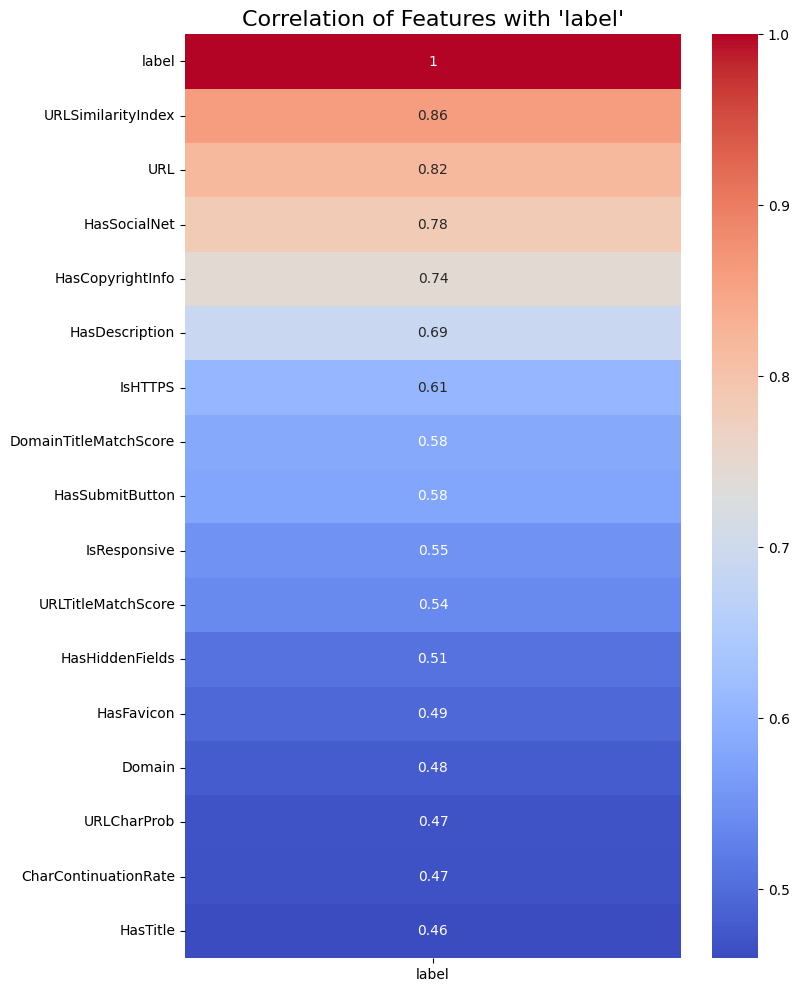

In [21]:
corr_with_label = df.corr(numeric_only=True)['label'].sort_values(ascending=False)

# Create a heatmap for correlation with 'label' only
plt.figure(figsize=(8, 12))
sns.heatmap(
    corr_with_label.to_frame(),
    annot=True,
    cmap='coolwarm',
    cbar=True
)
plt.title("Correlation of Features with 'label'", fontsize=16)
plt.show()

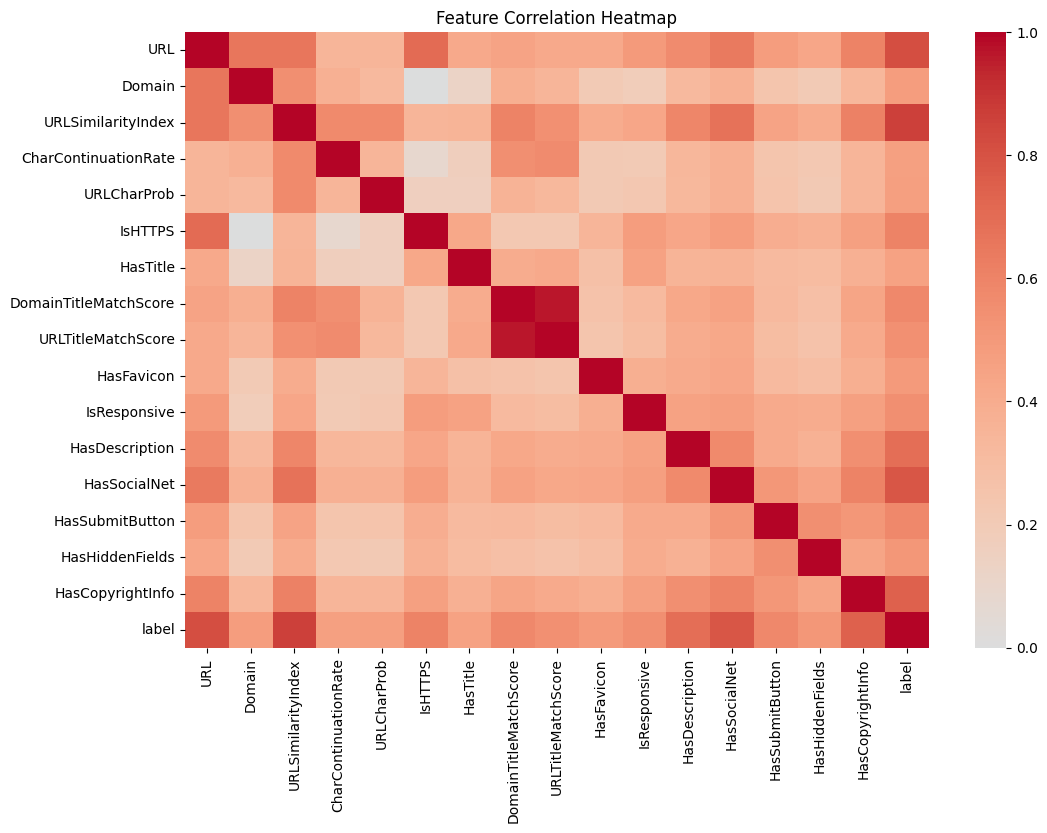

In [22]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [23]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# %pip install lightgbm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False),
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

results = {}

In [26]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}")

    results[name] = {
        "model": model,
        "accuracy": acc,
        "roc_auc": roc_auc
    }


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

ROC AUC: 0.9999


c:\myworks\Phishing_Detect\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:35:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

ROC AUC: 1.0000

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

ROC AUC: 1.0000


In [27]:
best_model_name = max(results, key=lambda k: results[k]["roc_auc"])
best_model = results[best_model_name]["model"]

print(f"\nBest Model: {best_model_name} (ROC AUC={results[best_model_name]['roc_auc']:.4f})")



Best Model: XGBoost (ROC AUC=1.0000)


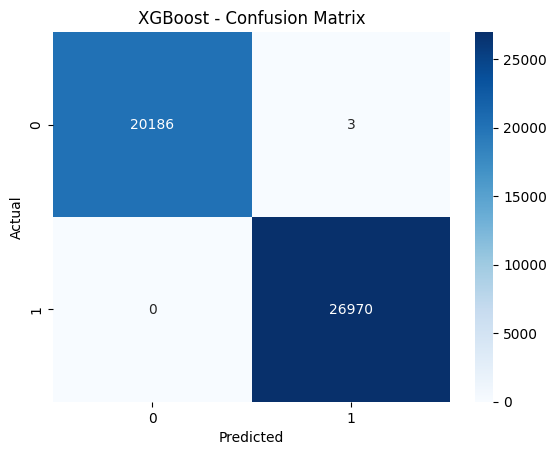

In [28]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_model_name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [29]:
import joblib
joblib.dump(best_model, "phishing_best_model.pkl")
joblib.dump(scaler, "phishing_scaler.pkl")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
